Cell 1 – Tiêu đề & mục tiêu

# 01 – EDA Pima Indians Diabetes

Mục tiêu notebook:

1. Giới thiệu dataset Pima Indians Diabetes và mục tiêu dự án.
2. Khảo sát cấu trúc dữ liệu: số dòng, cột, kiểu dữ liệu, phân bố biến mục tiêu.
3. Phát hiện và phân tích **missing ẩn** (các giá trị 0 vô lý) → chuyển về `NaN` cho EDA.
4. Phân tích thống kê mô tả (overall + theo nhóm Outcome).
5. Trực quan hoá các biến quan trọng: Glucose, BMI, Age, BloodPressure, Pregnancies, Insulin...
6. Khảo sát tương quan giữa các biến numeric.
7. Thử một số **feature engineering mang ý nghĩa y khoa** (BMI_Category, Age_Group, Risk-like score) để xem phân bố.

Lưu ý quan trọng về **Data Leakage**:

* Trong notebook này, mọi tính toán chỉ phục vụ **khám phá dữ liệu** (EDA).
* Việc `fit` imputer, scaler, SMOTE, model,… sẽ được thực hiện **chuẩn chỉ trong code OOP** (`DataPreprocessor`, `ModelTrainer`) và **chỉ trên tập Train**.
* Các thống kê trong notebook này **không được dùng lại** trực tiếp cho pipeline huấn luyện.


Cell 2 – Import thư viện & thiết lập chung

In [1]:
import logging
from pathlib import Path
from typing import List, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Thiết lập style cho plot
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)

# Thiết lập logging đơn giản cho notebook
logging.basicConfig(
    level=logging.INFO,
    format="[%(asctime)s] %(levelname)s - %(message)s",
)
logger = logging.getLogger("EDA_PIMA")

# Đảm bảo reproducibility cho mọi thao tác random (nếu có)
RANDOM_STATE: int = 42
np.random.seed(RANDOM_STATE)

pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 120)


Cell 3 – Xác định PROJECT_ROOT và đường dẫn dữ liệu (không hard-code)

In [2]:
def detect_project_root() -> Path:
    """
    Cố gắng suy ra PROJECT_ROOT một cách linh hoạt:
    - Nếu đang đứng ở project_root (có thư mục data/raw) → dùng cwd.
    - Nếu đang đứng ở notebooks/ → project_root = parent của cwd.
    - Nếu không đoán được → fallback về cwd.
    """
    cwd = Path.cwd().resolve()
    
    if (cwd / "data" / "raw").exists():
        return cwd
    if (cwd.parent / "data" / "raw").exists():
        return cwd.parent
    
    # Fallback: dùng cwd (in case chạy từ môi trường khác)
    return cwd


PROJECT_ROOT: Path = detect_project_root()
DATA_RAW_DIR: Path = PROJECT_ROOT / "data" / "raw"
DATA_PROCESSED_DIR: Path = PROJECT_ROOT / "data" / "processed"

logger.info("PROJECT_ROOT: %s", PROJECT_ROOT)
logger.info("DATA_RAW_DIR: %s", DATA_RAW_DIR)


[2025-12-11 21:07:02,599] INFO - PROJECT_ROOT: E:\3_CODING\Python\Python cho kdl\PRO\pima-diabetes-project\Nhom-3--Python-cho-KHDL---2025---2026\pima-diabetes-project
[2025-12-11 21:07:02,601] INFO - DATA_RAW_DIR: E:\3_CODING\Python\Python cho kdl\PRO\pima-diabetes-project\Nhom-3--Python-cho-KHDL---2025---2026\pima-diabetes-project\data\raw


Cell 4 – Load dữ liệu (có try/except chuẩn chỉnh)

In [3]:
RAW_DATA_PATH: Path = DATA_RAW_DIR / "diabetes.csv"

try:
    if not RAW_DATA_PATH.exists():
        raise FileNotFoundError(f"Không tìm thấy file: {RAW_DATA_PATH}")
    
    df_raw: pd.DataFrame = pd.read_csv(RAW_DATA_PATH)
    logger.info("Đã load dữ liệu: %s, shape = %s", RAW_DATA_PATH, df_raw.shape)
except Exception as e:
    logger.error("Lỗi khi load dữ liệu: %s", e)
    raise

df_raw.head(20)


[2025-12-11 21:07:02,646] INFO - Đã load dữ liệu: E:\3_CODING\Python\Python cho kdl\PRO\pima-diabetes-project\Nhom-3--Python-cho-KHDL---2025---2026\pima-diabetes-project\data\raw\diabetes.csv, shape = (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
5,5,116,74,0,0,25.6,0.201,30,0
6,3,78,50,32,88,31.0,0.248,26,1
7,10,115,0,0,0,35.3,0.134,29,0
8,2,197,70,45,543,30.5,0.158,53,1
9,8,125,96,0,0,0.0,0.232,54,1


Cell 6 – Phân bố biến mục tiêu (Outcome) & imbalance

Phân bố Outcome (0 = không tiểu đường, 1 = tiểu đường):


,count,ratio
Outcome,,
0,500,0.651
1,268,0.349


[2025-12-11 21:07:02,700] INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-12-11 21:07:02,706] INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


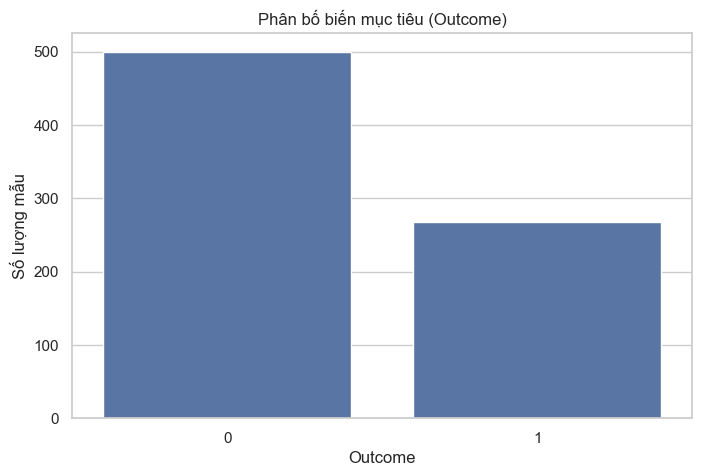

In [4]:
TARGET_COL: str = "Outcome"

if TARGET_COL not in df_raw.columns:
    raise ValueError(f"Không tìm thấy cột target '{TARGET_COL}' trong dữ liệu.")

target_counts = df_raw[TARGET_COL].value_counts().sort_index()
target_ratio = target_counts / len(df_raw)

print("Phân bố Outcome (0 = không tiểu đường, 1 = tiểu đường):")
display(pd.DataFrame({
    "count": target_counts,
    "ratio": target_ratio.round(4)
}))

# Plot
fig, ax = plt.subplots()
sns.barplot(
    x=target_counts.index.astype(str),
    y=target_counts.values,
    ax=ax
)
ax.set_xlabel("Outcome")
ax.set_ylabel("Số lượng mẫu")
ax.set_title("Phân bố biến mục tiêu (Outcome)")
plt.show()


Cell 7 – Phát hiện “missing ẩn” (0 vô lý) và chuyển thành NaN

In [5]:
HIDDEN_MISSING_COLS: List[str] = [
    "Glucose",
    "BloodPressure",
    "SkinThickness",
    "Insulin",
    "BMI",
]

def count_zeros(df: pd.DataFrame, cols: List[str]) -> pd.Series:
    """
    Đếm số lượng giá trị 0 trên từng cột chỉ định.
    Chỉ dùng cho EDA để phát hiện missing ẩn.
    """
    return df[cols].isin([0]).sum()

zeros_before = count_zeros(df_raw, [c for c in HIDDEN_MISSING_COLS if c in df_raw.columns])
print("Số lượng giá trị 0 (coi là missing ẩn) trước khi xử lý:")
display(zeros_before.to_frame("zero_count"))

df_eda = df_raw.copy()

for col in HIDDEN_MISSING_COLS:
    if col not in df_eda.columns:
        logger.warning("Cột %s không tồn tại, bỏ qua hidden missing.", col)
        continue
    df_eda.loc[df_eda[col] == 0, col] = np.nan

zeros_after = count_zeros(df_eda, [c for c in HIDDEN_MISSING_COLS if c in df_eda.columns])

print("\nSố lượng giá trị 0 sau khi chuyển 0 -> NaN:")
display(zeros_after.to_frame("zero_count_after"))

print("\nSố missing (NaN) sau xử lý hidden missing:")
display(df_eda[HIDDEN_MISSING_COLS].isna().sum().to_frame("missing_count"))


Số lượng giá trị 0 (coi là missing ẩn) trước khi xử lý:


,zero_count
Glucose,5
BloodPressure,35
SkinThickness,227
Insulin,374
BMI,11



Số lượng giá trị 0 sau khi chuyển 0 -> NaN:


,zero_count_after
Glucose,0
BloodPressure,0
SkinThickness,0
Insulin,0
BMI,0



Số missing (NaN) sau xử lý hidden missing:


,missing_count
Glucose,5
BloodPressure,35
SkinThickness,227
Insulin,374
BMI,11


Cell 8 – Bản đồ missing (tổng quan NaN)

Tổng quan missing value sau xử lý hidden missing:


,missing_count,missing_ratio
Insulin,374,0.4870
SkinThickness,227,0.2956
BloodPressure,35,0.0456
BMI,11,0.0143
Glucose,5,0.0065
Pregnancies,0,0.0000
DiabetesPedigreeFunction,0,0.0000
Age,0,0.0000
Outcome,0,0.0000


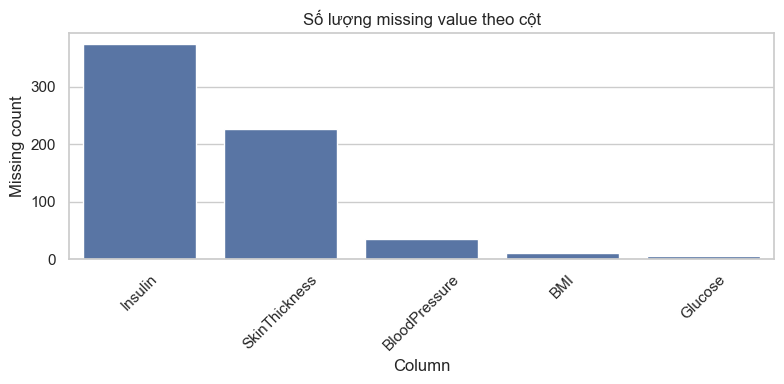

In [6]:
missing_counts = df_eda.isna().sum()
missing_ratio = missing_counts / len(df_eda)

missing_summary = pd.DataFrame({
    "missing_count": missing_counts,
    "missing_ratio": missing_ratio.round(4),
}).sort_values("missing_count", ascending=False)

print("Tổng quan missing value sau xử lý hidden missing:")
display(missing_summary)

# Barplot cột có missing
missing_nonzero = missing_summary[missing_summary["missing_count"] > 0]
if not missing_nonzero.empty:
    fig, ax = plt.subplots(figsize=(8, 4))
    sns.barplot(
        x=missing_nonzero.index,
        y=missing_nonzero["missing_count"],
        ax=ax,
    )
    ax.set_title("Số lượng missing value theo cột")
    ax.set_ylabel("Missing count")
    ax.set_xlabel("Column")
    ax.tick_params(axis="x", rotation=45)
    plt.tight_layout()
    plt.show()


Cell 9 – Thống kê mô tả các biến numeric (overall)

In [7]:
numeric_cols: List[str] = df_eda.select_dtypes(include=[np.number]).columns.tolist()
print("Các cột numeric:", numeric_cols)

describe_all = df_eda[numeric_cols].describe().T
describe_all["missing_count"] = df_eda[numeric_cols].isna().sum()
describe_all["missing_ratio"] = (
    describe_all["missing_count"] / len(df_eda)
).round(4)

display(describe_all)


Các cột numeric: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']


,count,mean,std,min,25%,50%,75%,max,missing_count,missing_ratio
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00,0,0.0000
Glucose,763.0,121.686763,30.535641,44.000,99.00000,117.0000,141.00000,199.00,5,0.0065
BloodPressure,733.0,72.405184,12.382158,24.000,64.00000,72.0000,80.00000,122.00,35,0.0456
SkinThickness,541.0,29.153420,10.476982,7.000,22.00000,29.0000,36.00000,99.00,227,0.2956
Insulin,394.0,155.548223,118.775855,14.000,76.25000,125.0000,190.00000,846.00,374,0.4870
BMI,757.0,32.457464,6.924988,18.200,27.50000,32.3000,36.60000,67.10,11,0.0143
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42,0,0.0000
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00,0,0.0000
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00,0,0.0000


Cell 10 – Thống kê theo nhóm Outcome (0 vs 1)

In [8]:
grouped_mean = df_eda.groupby(TARGET_COL)[numeric_cols].mean().T
grouped_median = df_eda.groupby(TARGET_COL)[numeric_cols].median().T

print("Giá trị TRUNG BÌNH của các biến numeric (theo Outcome):")
display(grouped_mean.round(2))

print("\nGiá trị TRUNG VỊ của các biến numeric (theo Outcome):")
display(grouped_median.round(2))


Giá trị TRUNG BÌNH của các biến numeric (theo Outcome):


Outcome,0,1
Pregnancies,3.30,4.87
Glucose,110.64,142.32
BloodPressure,70.88,75.32
SkinThickness,27.24,33.00
Insulin,130.29,206.85
BMI,30.86,35.41
DiabetesPedigreeFunction,0.43,0.55
Age,31.19,37.07
Outcome,0.00,1.00



Giá trị TRUNG VỊ của các biến numeric (theo Outcome):


Outcome,0,1
Pregnancies,2.00,4.00
Glucose,107.00,140.00
BloodPressure,70.00,74.50
SkinThickness,27.00,32.00
Insulin,102.50,169.50
BMI,30.10,34.30
DiabetesPedigreeFunction,0.34,0.45
Age,27.00,36.00
Outcome,0.00,1.00


Cell 11 – Hàm helper vẽ histogram/KDE theo Outcome

In [9]:
def plot_numeric_distribution_by_outcome(
    df: pd.DataFrame,
    col: str,
    target_col: str = "Outcome",
) -> None:
    """
    Vẽ phân bố một biến numeric theo 2 nhóm Outcome (0/1).
    Giúp nhìn trực quan xem biến nào phân biệt rõ giữa 2 nhóm.
    """
    if col not in df.columns:
        logger.warning("Cột %s không có trong DataFrame.", col)
        return
    
    fig, ax = plt.subplots()
    sns.kdeplot(
        data=df,
        x=col,
        hue=target_col,
        common_norm=False,
        ax=ax,
        fill=True,
        alpha=0.4,
    )
    ax.set_title(f"Phân bố {col} theo Outcome")
    plt.tight_layout()
    plt.show()


Cell 12 – Vẽ một số biến quan trọng (Glucose, BMI, Age, BloodPressure, Pregnancies)

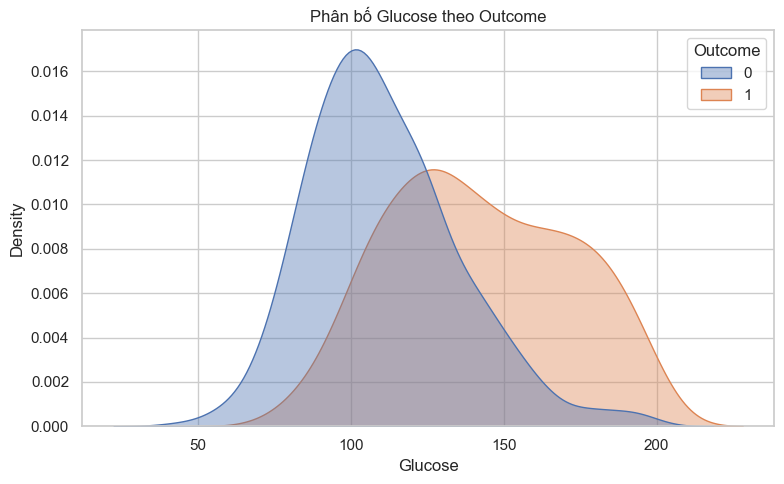

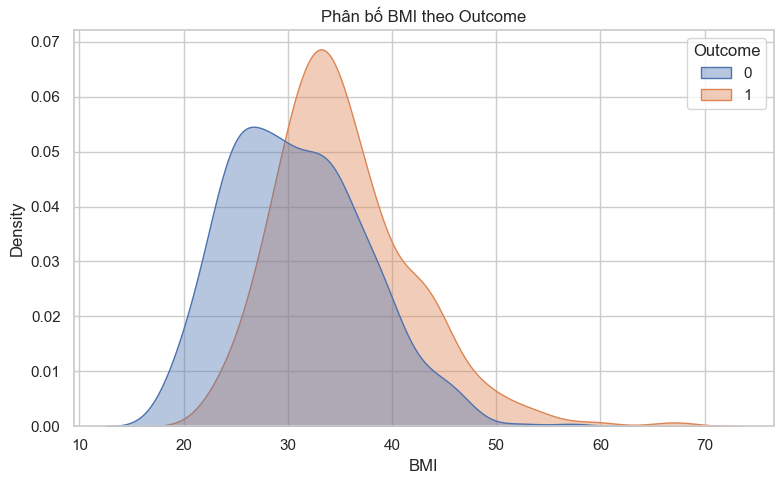

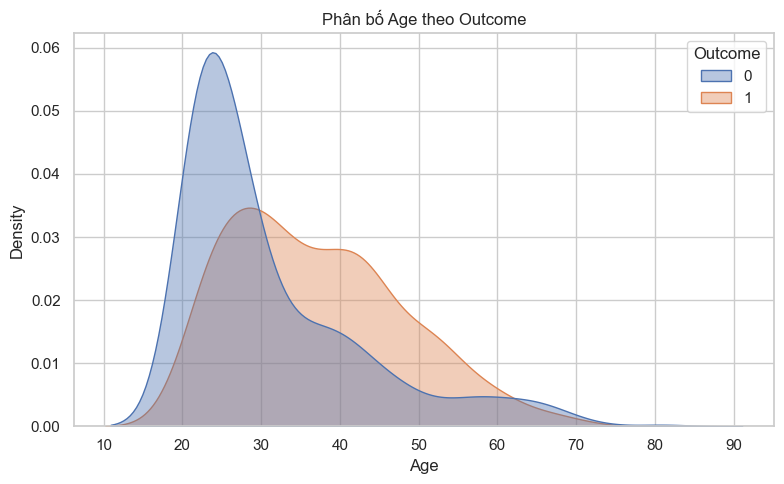

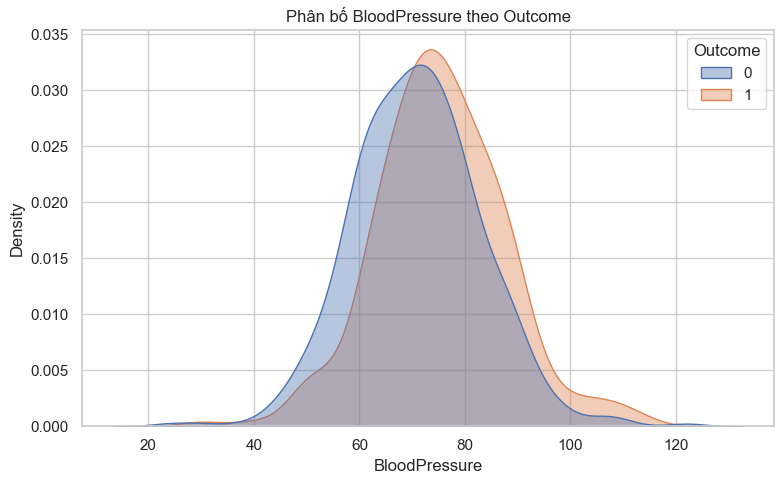

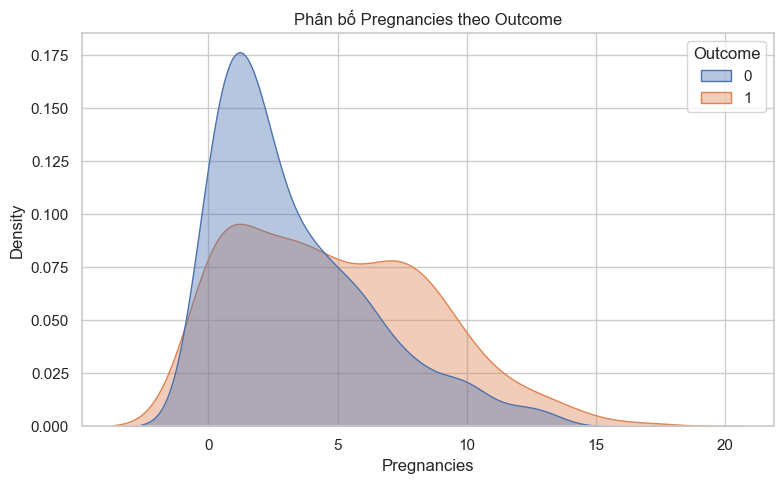

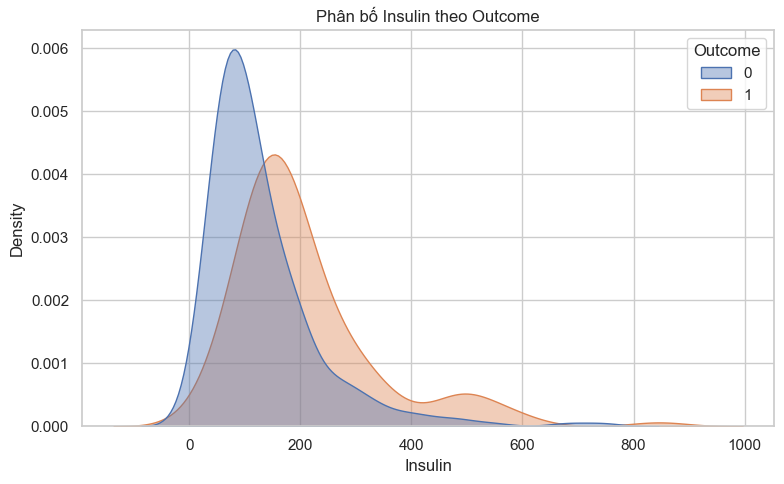

In [10]:
cols_to_plot: List[str] = [
    "Glucose",
    "BMI",
    "Age",
    "BloodPressure",
    "Pregnancies",
    "Insulin",
]

for c in cols_to_plot:
    if c in df_eda.columns:
        plot_numeric_distribution_by_outcome(df_eda, c, TARGET_COL)


Cell 13 – Boxplot theo Outcome cho một số biến

[2025-12-11 21:07:03,979] INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-12-11 21:07:03,989] INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-12-11 21:07:04,013] INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-12-11 21:07:04,019] INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-12-11 21:07:04,038] INFO - Using categorical units to plot a list of strings that are all parsable as 

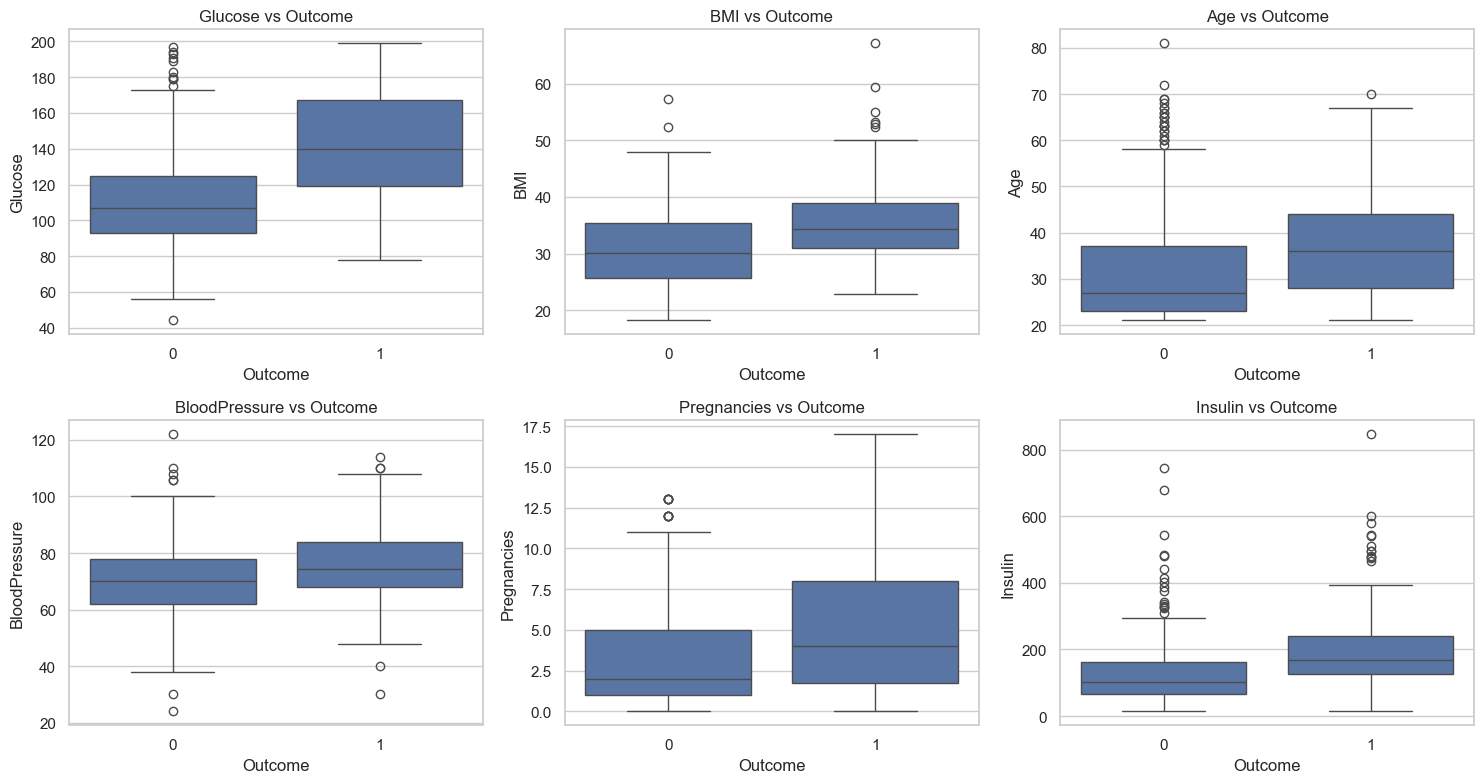

In [11]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for ax, col in zip(axes, cols_to_plot):
    if col not in df_eda.columns:
        ax.set_visible(False)
        continue
    sns.boxplot(
        data=df_eda,
        x=TARGET_COL,
        y=col,
        ax=ax,
    )
    ax.set_title(f"{col} vs Outcome")

plt.tight_layout()
plt.show()


Cell 14 – Ma trận tương quan & heatmap

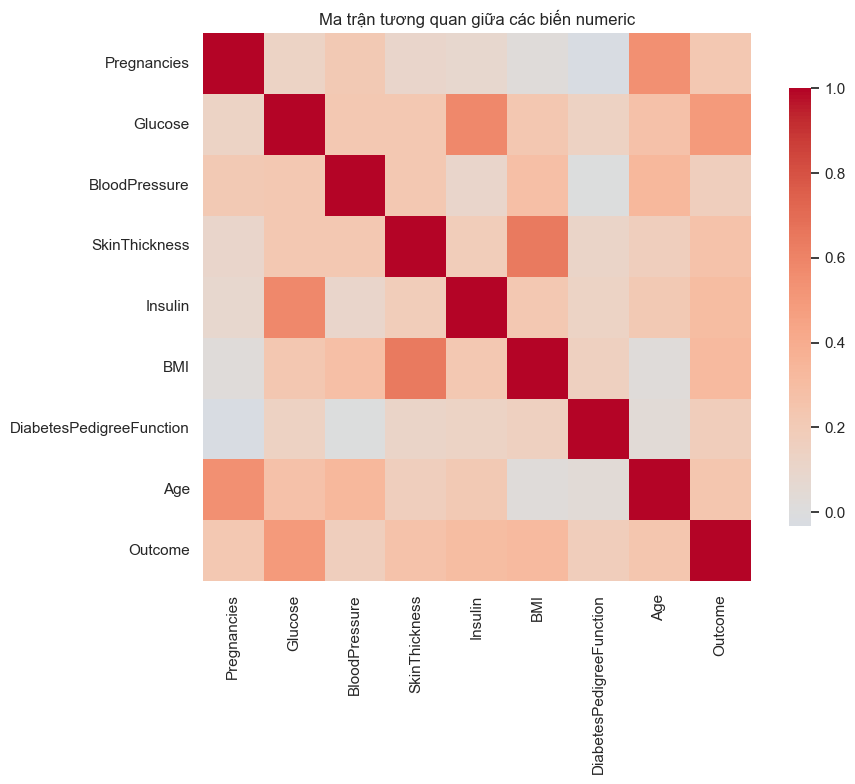

In [12]:
corr_matrix = df_eda[numeric_cols].corr()

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    cmap="coolwarm",
    center=0,
    square=True,
    cbar_kws={"shrink": 0.8},
)
ax.set_title("Ma trận tương quan giữa các biến numeric")
plt.tight_layout()
plt.show()


Cell 15 – Feature Engineering cho EDA (BMI_Category, Age_Group, Pregnancy_high, Risk_Score demo)

In [13]:
df_feat = df_eda.copy()

# BMI_Category
if "BMI" in df_feat.columns:
    df_feat["BMI_Category"] = pd.cut(
        df_feat["BMI"],
        bins=[0, 18.5, 25, 30, np.inf],
        labels=["Underweight", "Normal", "Overweight", "Obese"],
        include_lowest=True,
    )

# Age_Group
if "Age" in df_feat.columns:
    df_feat["Age_Group"] = pd.cut(
        df_feat["Age"],
        bins=[20, 30, 40, 50, 120],
        labels=["21-30", "31-40", "41-50", ">50"],
        include_lowest=True,
    )

# Pregnancy_high (>=3 lần mang thai)
if "Pregnancies" in df_feat.columns:
    df_feat["Pregnancy_high"] = (df_feat["Pregnancies"] >= 3).astype(int)

# Risk_Score (chỉ là demo đơn giản cho EDA, KHÔNG dùng trực tiếp cho modeling)
if {"Glucose", "BMI"} <= set(df_feat.columns):
    # Chuẩn hóa tuyến tính đơn giản theo min-max chỉ để xem EDA (trên toàn bộ dataset)
    glu_norm = (df_feat["Glucose"] - df_feat["Glucose"].min()) / (df_feat["Glucose"].max() - df_feat["Glucose"].min())
    bmi_norm = (df_feat["BMI"] - df_feat["BMI"].min()) / (df_feat["BMI"].max() - df_feat["BMI"].min())
    df_feat["Risk_Score_demo"] = 0.6 * glu_norm + 0.4 * bmi_norm

df_feat.head()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,BMI_Category,Age_Group,Pregnancy_high,Risk_Score_demo
0,6,148.0,72.0,35.0,NaN,33.6,0.627,50,1,Obese,41-50,1,0.528552
1,1,85.0,66.0,29.0,NaN,26.6,0.351,31,0,Overweight,31-40,0,0.227421
2,8,183.0,64.0,NaN,NaN,23.3,0.672,32,1,Normal,31-40,1,0.579782
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0,Overweight,21-30,0,0.255175
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1,Obese,31-40,0,0.563681


Lưu ý trong báo cáo: Risk_Score_demo chỉ là feature minh hoạ trong EDA (giúp thuyết trình ý tưởng), còn pipeline chính sẽ làm feature engineering đúng chuẩn trong DataPreprocessor.

Cell 16 – Phân bố Outcome theo BMI_Category & Age_Group

In [14]:
def crosstab_ratio(df: pd.DataFrame, col: str, target_col: str = "Outcome") -> pd.DataFrame:
    """
    Tạo bảng cross-tab giữa một feature dạng category và Outcome,
    kèm theo tỉ lệ bệnh nhân tiểu đường trong từng nhóm.
    """
    ct = pd.crosstab(df[col], df[target_col])
    if 1 in ct.columns:
        ct["diabetes_ratio"] = (ct[1] / ct.sum(axis=1)).round(3)
    return ct

if "BMI_Category" in df_feat.columns:
    print("Phân bố Outcome theo BMI_Category:")
    display(crosstab_ratio(df_feat, "BMI_Category", TARGET_COL))

if "Age_Group" in df_feat.columns:
    print("\nPhân bố Outcome theo Age_Group:")
    display(crosstab_ratio(df_feat, "Age_Group", TARGET_COL))


Phân bố Outcome theo BMI_Category:


Outcome,0,1,diabetes_ratio
BMI_Category,,,
Underweight,4,0,0.000
Normal,101,7,0.065
Overweight,136,44,0.244
Obese,250,215,0.462



Phân bố Outcome theo Age_Group:


Outcome,0,1,diabetes_ratio
Age_Group,,,
21-30,327,90,0.216
31-40,81,76,0.484
41-50,49,64,0.566
>50,43,38,0.469


## Kết luận EDA tóm tắt

1. **Missing ẩn & Missing thật:**
   - Các cột Glucose, BloodPressure, SkinThickness, Insulin, BMI xuất hiện rất nhiều giá trị 0.
   - Với góc nhìn y khoa, các giá trị 0 này được xem là **missing ẩn** và đã được chuyển thành `NaN` trong EDA.
   - Tỉ lệ missing cao nhất ở SkinThickness, Insulin → cần imputation cẩn thận (Median theo Outcome / Age Group).

2. **Imbalance dữ liệu:**
   - Outcome=1 (tiểu đường) chiếm khoảng X% (từ bảng thống kê), Outcome=0 chiếm Y%.
   - Dataset **bất cân bằng**, do đó trong modeling cần:
     - `stratify=y` khi chia train/test.
     - Dùng `class_weight='balanced'` hoặc `SMOTE` khi huấn luyện.

3. **Khác biệt giữa nhóm có bệnh / không bệnh:**
   - Glucose và BMI ở nhóm Outcome=1 có xu hướng cao hơn rõ rệt so với Outcome=0.
   - Một số feature khác như Age, Pregnancies cũng cho thấy sự khác biệt (nhất là ở nhóm Age > 40).

4. **Feature Engineering gợi ý:**
   - `BMI_Category` (Underweight/Normal/Overweight/Obese).
   - `Age_Group` (21–30, 31–40, 41–50, >50).
   - `Pregnancy_high` (>= 3 lần mang thai).
   - Risk-like score kết hợp Glucose + BMI (chỉ dùng minh hoạ trong EDA, pipeline chính sẽ thiết kế bài bản hơn).

5. **Liên hệ với pipeline OOP:**
   - Các insight từ EDA dẫn tới quyết định thiết kế `DataPreprocessor`:
     - Xử lý **hidden missing** bằng cách chuyển 0 → NaN.
     - Imputation numeric bằng **median theo nhóm Outcome** (hoặc nhóm tuổi) thay vì mean toàn cục.
   - Phần modeling (trong `ModelTrainer`) sẽ:
     - Cố định `random_state`,
     - Dùng `stratify=y` khi split,
     - Áp dụng `class_weight='balanced'` / `SMOTE`,
     - Đánh giá bằng F1-Score và ROC-AUC,
     - Giải thích bằng Feature Importance + SHAP (Explainable AI).
